!pip install torchvision

In [2]:
import sys
sys.path.append('./scripts/')
from datasets import *
import scipy.ndimage
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"


dataset='ilsvrc12'
paths, count, y, idx_to_labels = get_dataset(dataset)

print(count, len(paths))

10000 10000


In [3]:
idx_to_labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [6]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)

model.eval()

Using cache found in /home/mara/.cache/torch/hub/pytorch_vision_v0.9.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
#layer='layer4.0.add'
layer='Mixed_7b.cat_2'
SAVEFOLD=f'outputs/{dataset}'
if not os.path.exists(SAVEFOLD):
    os.mkdir(SAVEFOLD)

In [9]:
try:
    os.mkdir(f"{SAVEFOLD}/{layer}/")
except:
    print("Maybe the directory already exists? ")
SAVEFOLD=f"{SAVEFOLD}/{layer}/"

Maybe the directory already exists? 


In [10]:
classes = np.unique(y)

In [11]:
SAVEFOLD

'outputs/ilsvrc12/Mixed_7b.cat_2/'

In [12]:
print(layer)
return_nodes={f'{layer}': 'conv', 'avgpool':'avgpool', 'fc':'fc'
             }
model = torchvision.models.feature_extraction.create_feature_extractor(model, return_nodes=return_nodes)

Mixed_7b.cat_2


In [14]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
inputs=torch.zeros((8,3,299,299), dtype=torch.float).to(device)
model.to(device)
outs=model(inputs)
dim_c = outs['conv'].shape[1]
dim_w = outs['conv'].shape[2]
dim_h = outs['conv'].shape[3]

In [15]:
print(dim_c, dim_w, dim_h)

2048 8 8


In [16]:
import cdisco.cdisco

In [ ]:
"""
COMPUTE model state
"""
# cdisco.cdisco.get_model_state(model, paths, y, dim_c, dim_w, dim_h, SAVEFOLD=SAVEFOLD)

In [18]:
"""
LOAD precomputed model state
"""

gradients_wrt_conv_layer=np.load(f"{SAVEFOLD}/gradients_wrt_conv_layer.npy")
predictions=np.load(f"{SAVEFOLD}/predictions.npy")
conv_maps=np.load(f"{SAVEFOLD}/conv_maps.npy")

## only if CDISCO was already run once
class_concept_candidates=np.load(f"{SAVEFOLD}/cdisco_candidates.npy", allow_pickle=True).item()
pvh=np.load(f"{SAVEFOLD}/eigenvectors.npy",allow_pickle=True)

In [19]:
class_concept_candidates=np.load(f"{SAVEFOLD}/cdisco_candidates.npy", allow_pickle=True).item()

In [20]:
class_concept_candidates[340]

array([1039, 1997,  677, ...,   25, 1339, 1797])

In [ ]:
""" 
RUN CONCEPT DISCOVERY
"""
class_concept_candidates, pvh = cdisco.cdisco.cdisco(conv_maps, gradients_wrt_conv_layer, predictions, classes)

np.save(f"{SAVEFOLD}/cdisco_candidates.npy", class_concept_candidates)
np.save(f"{SAVEFOLD}/eigenvectors.npy", pvh)

In [ ]:
class_concept_candidates=np.load(f"{SAVEFOLD}/cdisco_candidates.npy", allow_pickle=True)

In [ ]:
class_concept_candidates=class_concept_candidates.item()

In [ ]:
classes=np.unique(y)
concepts, candidates=cdisco.cdisco.cdisco_concepts_list(class_concept_candidates,classes,limit=1)

In [ ]:
len(candidates)

First candidate:  577 20.0
Second: 1182 14.0
Third: 577 11.0


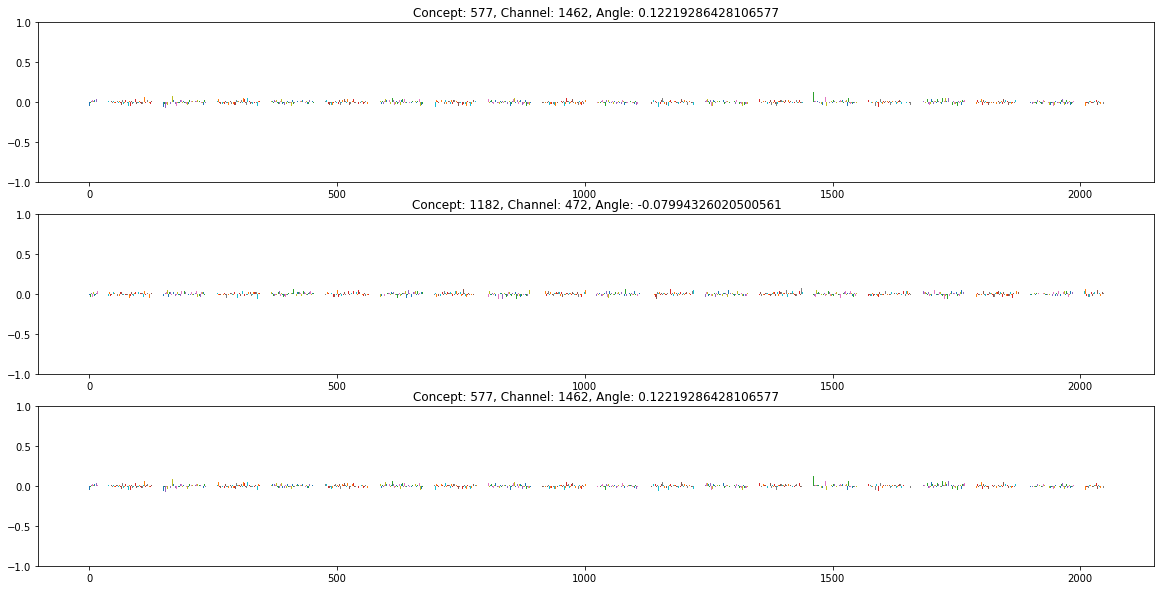

In [14]:
import cdisco.analyze
#imp.reload(cdisco.analyze)
cdisco.analyze.cdisco_pop_concepts(class_concept_candidates, classes, pvh, savefold=SAVEFOLD)   

In [ ]:
cdisco.analyze.cdisco_angle_dissection(pvh, candidates, savefold=SAVEFOLD)

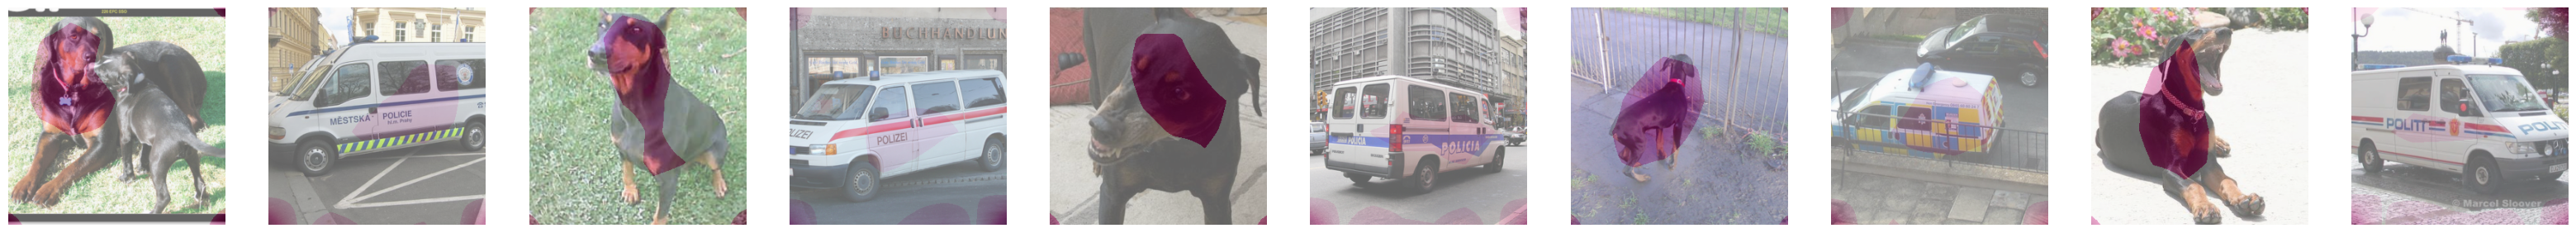

In [64]:
plt.rcParams['figure.figsize']=(40,20)
import cdisco.vis
#conc=1671
dim_c=2048
dim_w=dim_h=8
all_images=[]
for c in [1221]:#,1039,808]: #[11]: #[395, 578,188,91]:
    concept_vector = v1.T #pvh[c,:]  # this is the eigenvector = the concept that we want to visualize
    classes_with_concept = candidates[c][:]
    image_idxs=[]
    class_iterator=0
    image_iterator=0
    while len(image_idxs)<10:
        cwc=classes_with_concept[class_iterator]
        cc_= np.argwhere(int(cwc)==np.argmax(predictions,axis=1))
        
        image_idxs.append(cc_[image_iterator].ravel()[0])
        class_iterator+=1
        if (class_iterator==len(classes_with_concept)):
            image_iterator+=1
            class_iterator=0
    #for cwc in classes_with_concept:
    #    cc_= np.argwhere(int(cwc)==np.argmax(predictions,axis=1))
    #    for iterator in range(bs):
    #        image_idxs.append(cc_[iterator].ravel()[0])
    #import pdb; pdb.set_trace()
        #image_idxs[start:(start+bs)] = cc_[:bs].ravel()
        #start+=bs
    
    i=1
    
    images = image_idxs[:10]
    all_images.append(images)
    for img_id in images[:20]:
        plt.subplot(2,len(images),i)
        #img_id=img_id[0]
        #print(c, img_id)
        fmap=cdisco.vis.cdisco_concept_vis(img_id, concept_vector, dim_c, dim_w, dim_h, conv_maps)
        #plt.figure()
        plt.imshow((transform(Image.open(paths[img_id]))).swapaxes(0,1).swapaxes(1,-1))#,alpha=0.5)
        
        hmap=scipy.ndimage.zoom(fmap, 299/fmap.shape[0],order=1)
        th = np.percentile(hmap,85) 
        plt.imshow((hmap>th)*hmap, cmap='PiYG_r', alpha=0.4, vmin=-np.abs(hmap).max(), vmax=np.abs(hmap).max())
        #plt.savefig(f"{SAVEFOLD}_j_{img_id}.png")
        plt.axis("off")
        i+=1
    
    plt.savefig(f"{SAVEFOLD}_concept_map_{c}_everything_v1.png")
        

In [17]:
len(cc_)

9

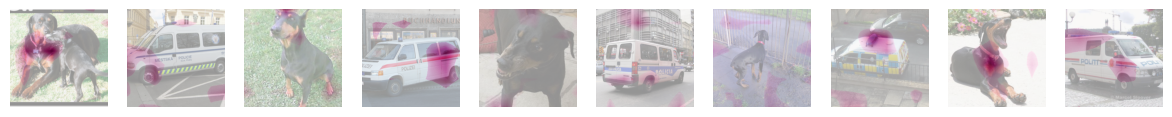

In [21]:
plt.rcParams['figure.figsize']=(30,8)
i=1
for img_id in images[:100]:
        plt.subplot(5,20,i)
        #img_id=img_id[0]
        #print(c, img_id)
        fmap=cdisco.vis.cdisco_concept_vis(img_id, concept_vector, dim_c, dim_w, dim_h, conv_maps)
        #plt.figure()
        plt.imshow((transform(Image.open(paths[img_id]))).swapaxes(0,1).swapaxes(1,-1))#,alpha=0.5)
        
        hmap=scipy.ndimage.zoom(fmap, 299/fmap.shape[0],order=1)
        th = np.percentile(hmap,85) 
        plt.imshow((hmap>th)*hmap, cmap='PiYG_r', alpha=0.6, vmin=-np.abs(hmap).max(), vmax=np.abs(hmap).max())
        #plt.savefig(f"{SAVEFOLD}_j_{img_id}.png")
        plt.axis("off")                                  
        i+=1
    
plt.savefig(f"{SAVEFOLD}_concept_map_{c}_everything.png")
        

In [20]:
img_id

7345

In [15]:
activations=[]
for img_id in all_images[:100]:
    activations.append(conv_maps[img_id])

In [16]:
activations=np.concatenate(activations)

In [18]:
activations.shape

(10, 2048, 8, 8)

In [26]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, n_init=5, max_iter=1000).fit(np.mean(activations, axis=(2,3)))

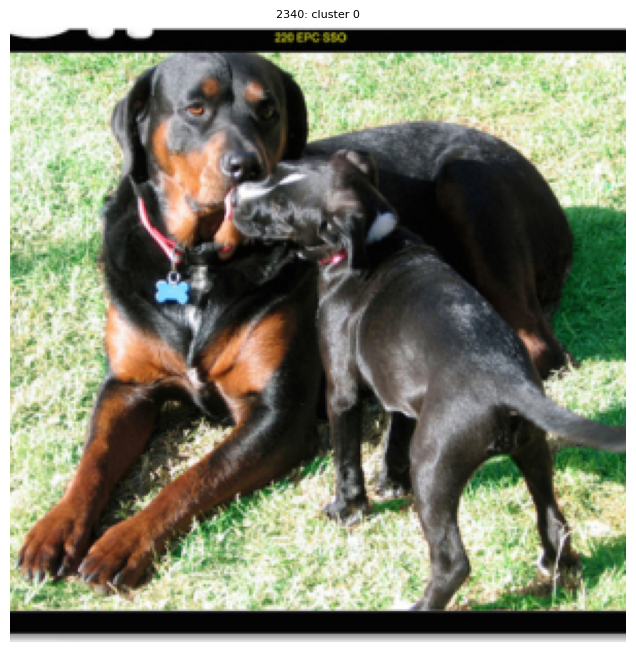

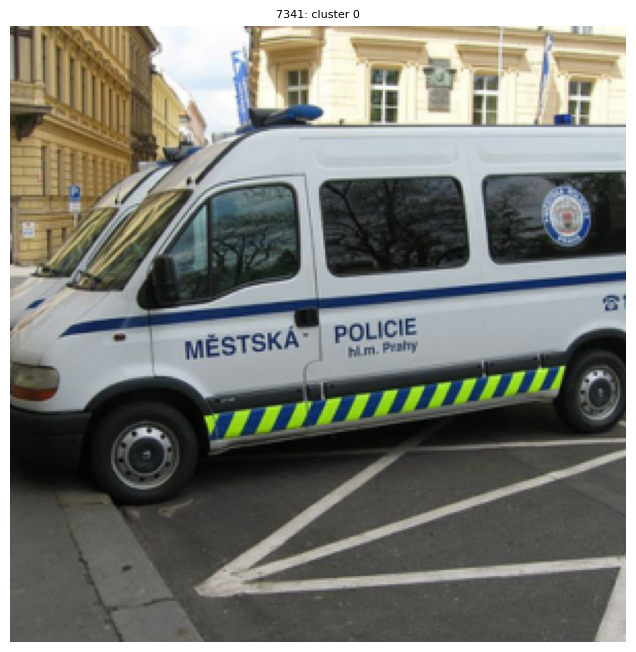

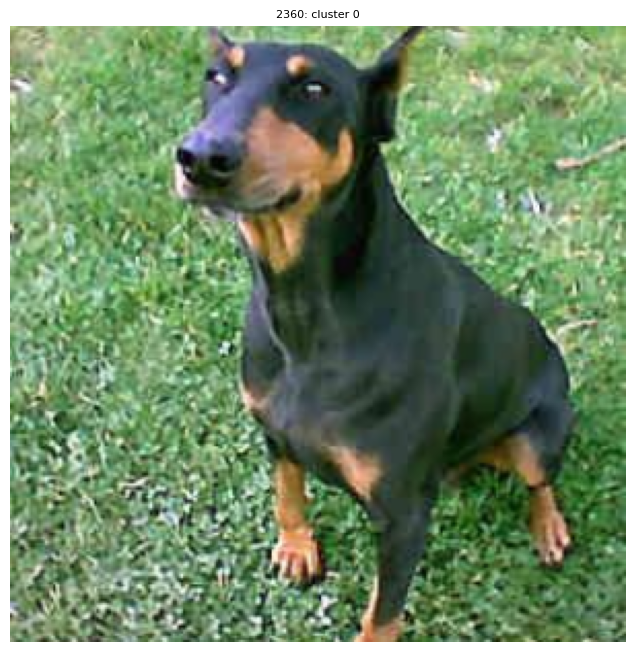

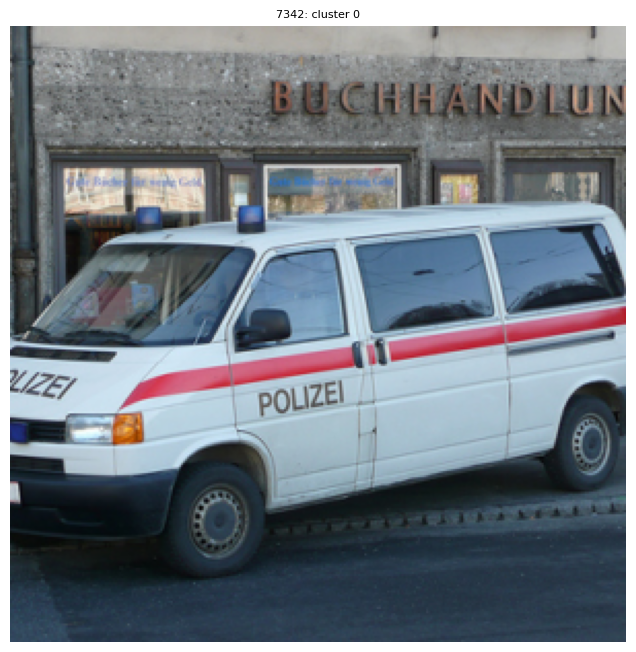

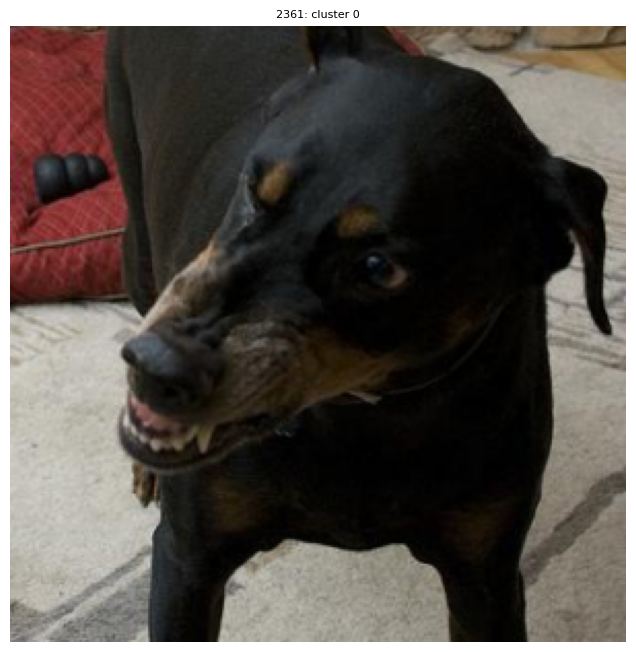

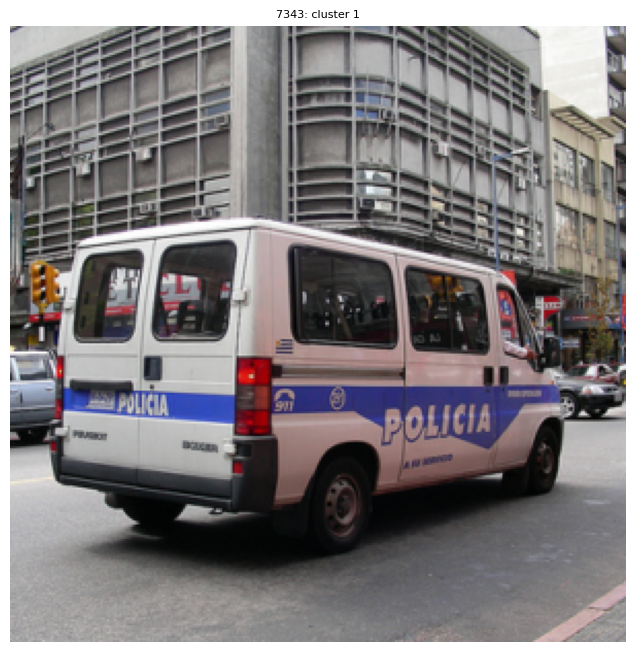

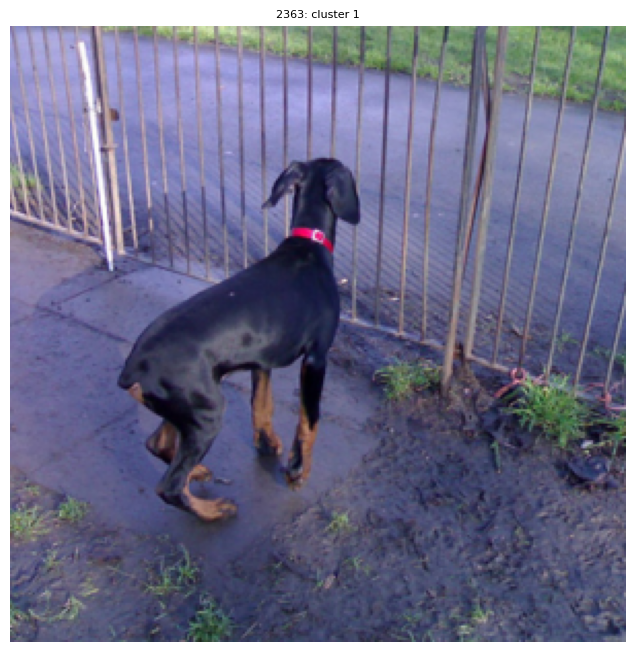

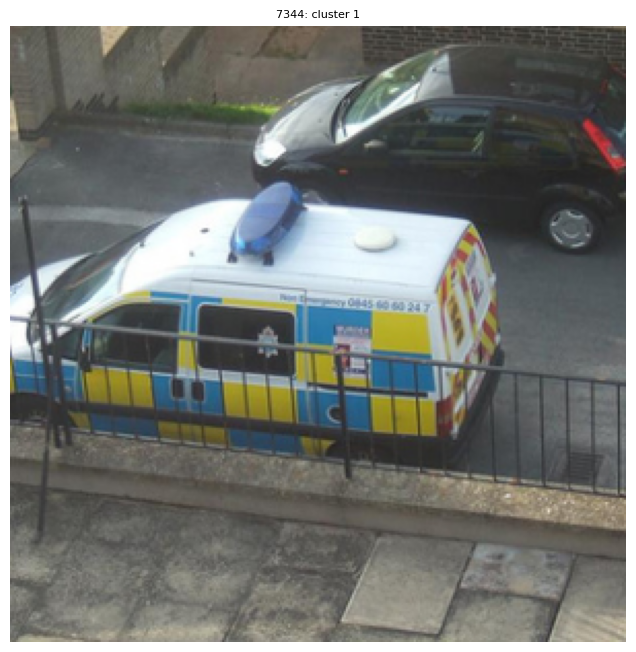

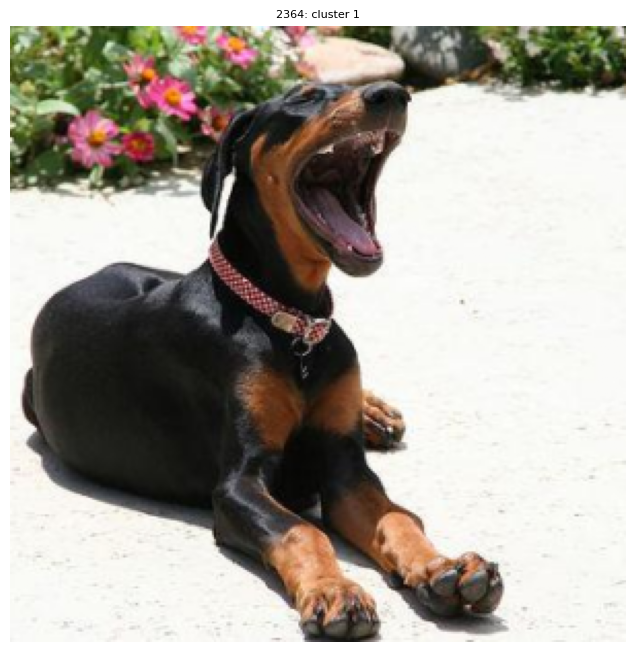

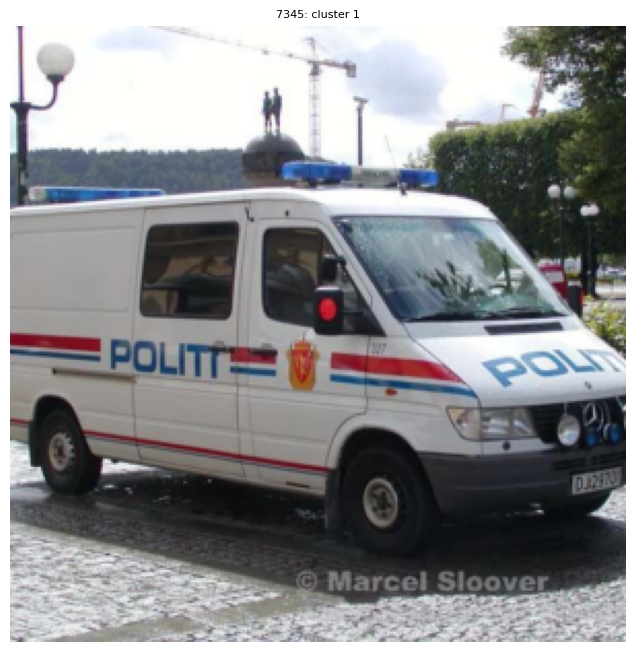

In [36]:
import math
clu_labs = kmeans.labels_

clu_lab_order = sorted(range(len(clu_labs)), key=lambda k: clu_labs[k])

idx = 0
for idx, im_id in enumerate(images):
    #im = Image.open(paths[im_id])
    plt.figure()
    plt.imshow((transform(Image.open(paths[im_id]))).swapaxes(0,1).swapaxes(1,-1))#,alpha=0.5
    plt.title(f"{im_id}: cluster {clu_labs[clu_lab_order][idx]}", size = 8)
    plt.axis('off')
    #idx+=1

In [ ]:
import umap.umap_ as umap

# Scatterplot to visualise clusters
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink',
                   'green', 'purple', 'yellow'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot
def clustering_scatterplot(points, labels, centers, title):
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1],
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))
    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')
    
XY_UMAP = umap.UMAP(n_components=2).fit_transform(np.mean(activations, axis=(2,3)))
clustering_scatterplot(points=XY_UMAP, 
                       labels=clu_labs,
                       centers=None, 
                       title='UMAP')

In [ ]:
import umap.umap_ as umap
XY_UMAP = umap.UMAP(n_components=2).fit_transform(np.mean(activations, axis=(2,3)))

In [ ]:
# For UMAP plot
def getImage(path, zoom=0.1):
    return OffsetImage(plt.imread(path), zoom=zoom)

def rand_jitter(arr, amount):
    stdev = amount * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, ax, s=20, c='b', marker='o', cmap=None, norm=None,
           vmin=None, vmax=None, alpha=None, linewidths=None,
           verts=None, hold=None, **kwargs):
    return ax.scatter(rand_jitter(x, amount), rand_jitter(y, amount),
                      s=s, c=c, marker=marker, cmap=cmap,
                      norm=norm, vmin=vmin, vmax=vmax, alpha=alpha,
                      linewidths=linewidths, **kwargs)

In [37]:
clu_labs

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0], dtype=int32)

In [57]:
clu1 = []
clu2 = []
i=0
for im in images:
    if clu_labs[i]==1:
        clu1.append(np.mean(conv_maps[im,:,:], axis=(1,2)))
    else:
        clu2.append(np.mean(conv_maps[im,:,:], axis=(1,2))   )         
    i+=1

In [56]:
conv_maps.shape

(10000, 2048, 8, 8)

In [58]:
v1 = np.mean(np.asarray(clu1), axis=0)
v2 = np.mean(np.asarray(clu2),axis=0)

In [ ]:
plt.rcParams['figure.figsize']=(40,20)
import cdisco.vis
#conc=1671
dim_c=2048
dim_w=dim_h=8
all_images=[]
for c in [1221]:#,1039,808]: #[11]: #[395, 578,188,91]:
    concept_vector = pvh[c,:]  # this is the eigenvector = the concept that we want to visualize
    classes_with_concept = candidates[c][:]
    image_idxs=[]
    class_iterator=0
    image_iterator=0
    while len(image_idxs)<10:
        cwc=classes_with_concept[class_iterator]
        cc_= np.argwhere(int(cwc)==np.argmax(predictions,axis=1))
        
        image_idxs.append(cc_[image_iterator].ravel()[0])
        class_iterator+=1
        if (class_iterator==len(classes_with_concept)):
            image_iterator+=1
            class_iterator=0
    #for cwc in classes_with_concept:
    #    cc_= np.argwhere(int(cwc)==np.argmax(predictions,axis=1))
    #    for iterator in range(bs):
    #        image_idxs.append(cc_[iterator].ravel()[0])
    #import pdb; pdb.set_trace()
        #image_idxs[start:(start+bs)] = cc_[:bs].ravel()
        #start+=bs
    
    i=1
    
    images = image_idxs[:10]
    all_images.append(images)
    for img_id in images[:20]:
        plt.subplot(2,len(images),i)
        #img_id=img_id[0]
        #print(c, img_id)
        fmap=cdisco.vis.cdisco_concept_vis(img_id, concept_vector, dim_c, dim_w, dim_h, conv_maps)
        #plt.figure()
        plt.imshow((transform(Image.open(paths[img_id]))).swapaxes(0,1).swapaxes(1,-1))#,alpha=0.5)
        
        hmap=scipy.ndimage.zoom(fmap, 299/fmap.shape[0],order=1)
        th = np.percentile(hmap,85) 
        plt.imshow((hmap>th)*hmap, cmap='PiYG_r', alpha=0.4, vmin=-np.abs(hmap).max(), vmax=np.abs(hmap).max())
        #plt.savefig(f"{SAVEFOLD}_j_{img_id}.png")
        plt.axis("off")
        i+=1
    
    plt.savefig(f"{SAVEFOLD}_concept_map_{c}_everything.png")
        

In [59]:
v1.shape, v2.shape, len(clu1), clu1[0].shape

((2048,), (2048,), 5, (2048,))

(6.1, 10.0)

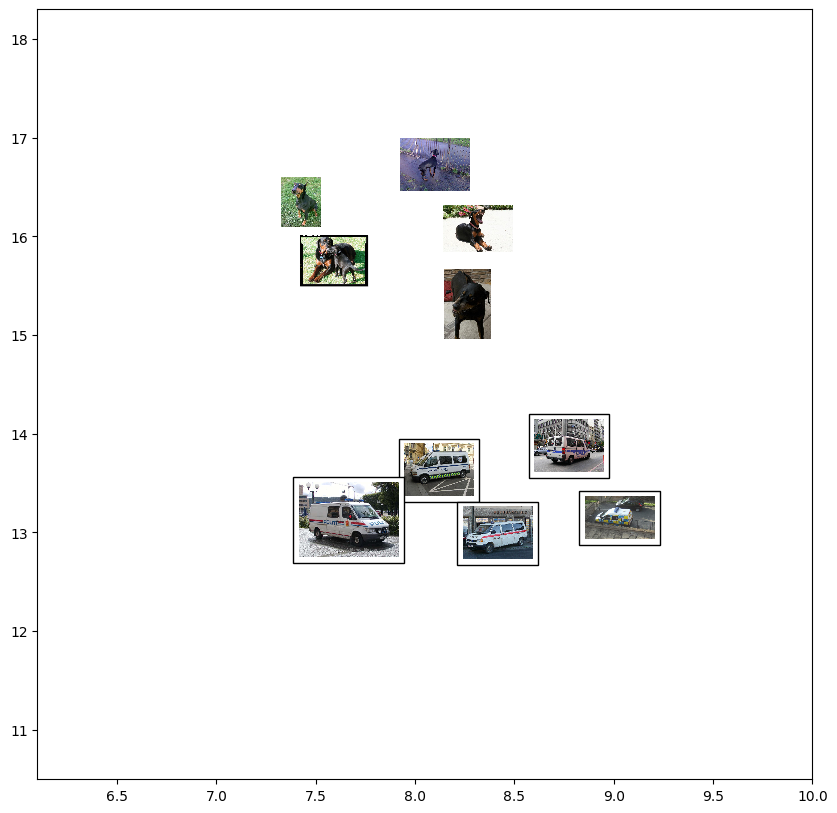

In [35]:
#clu_labs=np.zeros(30)
clu_labs = kmeans.labels_
# print(clu_labs)
clu_lab_order = sorted(range(len(clu_labs)), key=lambda k: clu_labs[k])
fig, ax = plt.subplots(figsize = (10,10))
#ax.set_title("UMAP")
amount=0.
ax.scatter(XY_UMAP[:,0], XY_UMAP[:,1]) 
top_ims=images
bool_cluster=False
i=0
for x0, y0, path in zip(rand_jitter(XY_UMAP[:,0], amount), rand_jitter(XY_UMAP[:,1], amount), [paths[i] for i in top_ims]):
    bool_cluster=False
    if clu_labs[i]==0: 
        bool_cluster=True 
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=bool_cluster)
    ax.add_artist(ab)
    i+=1

plt.ylim((10.5,18.3))
plt.xlim((6.1,10.0))

In [40]:
top_ims=np.concatenate(all_images)

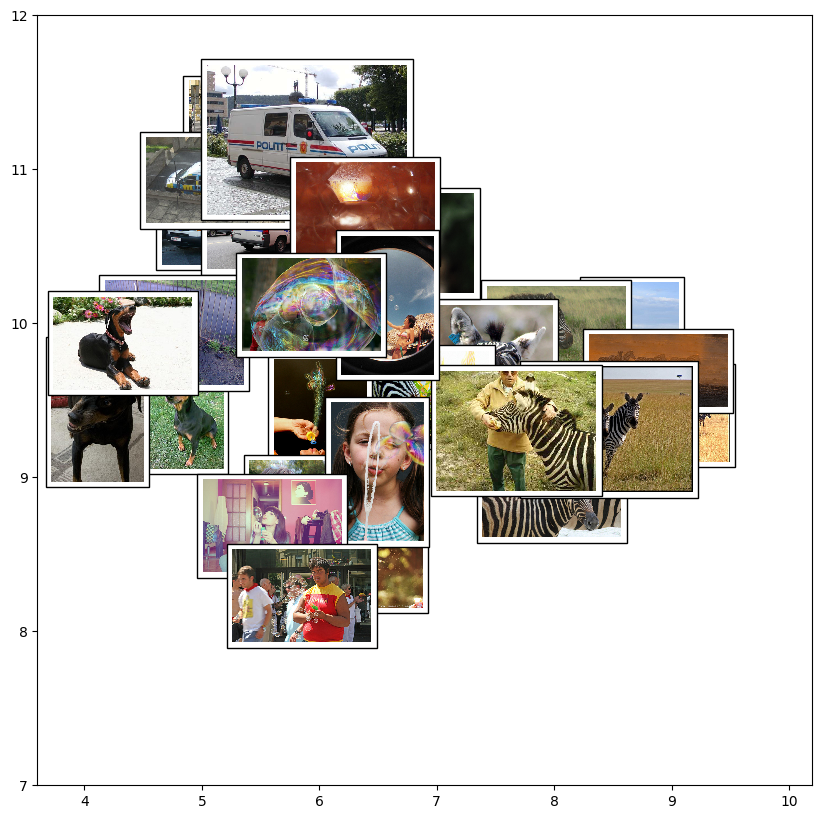

In [45]:
fig, ax = plt.subplots(figsize = (20,20))
amount=0.
clu_labs=np.zeros(31)
ax.scatter(XY_UMAP[:,0], XY_UMAP[:,1]) 
i=0
for x0, y0, path in zip(rand_jitter(XY_UMAP[:,0], amount), rand_jitter(XY_UMAP[:,1], amount), [paths[i] for i in top_ims]):
    bool_cluster=False
    if clu_labs[i]==0: 
        bool_cluster=False 
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=bool_cluster)
    ax.add_artist(ab)
    i+=1

plt.ylim((7,12))
plt.xlim((3.6,10.2))
plt.show()